# Snake Species Identification Challenge

This notebook offers another possible solution to the challenge proposed by crowdAI (https://www.aicrowd.com/challenges/snake-species-identification-challenge). This notebook is the second solution proposed (the first is Snake Classification). Instead of taking the ResNet50 and retraining it, we will add some dropout layers in order to see if we can get better validation results.


In [1]:
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn
import tensorboardX
import numpy as np
from sklearn.metrics import f1_score
import os
import copy
import fastai
import cv2 as cv
from PIL import Image
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import pylab
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print("Device: " + str(torch.cuda.get_device_name(0)))

cuda
Device: Tesla K80


### Dataset Preparation

__WARNING__: This script assumes that the dataset has been previously splitted. This process is done by the script split_dataset.py, provided in this repository. Before running this script, run split_dataset.py


### Datasets & Dataloaders creation

Once the dataset is splitted, we proceed to create the training and validation datasets. Since we are dealing with images, we can take advantage of the ImageFolder class that torchvision provides.

In [2]:
train_dir = '/home/user/snakes/train/'
validation_dir = '/home/user/snakes/validation/'

# Define training parameters 
size_batch = 16

# Like Albert Pumarola said in class, normalize data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# Define datasets
training_set = torchvision.datasets.ImageFolder(train_dir, transforms.Compose([transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]))
validation_set = torchvision.datasets.ImageFolder(validation_dir, transforms.Compose([transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]))
                                    
# Define dataloaders                               
train_loader = torch.utils.data.DataLoader(training_set, batch_size=size_batch, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=size_batch, shuffle=True, num_workers=2, pin_memory=True)

/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:691: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:691: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


Now that datasets and dataloaders are defined, we define the loss function. As we are  tackling a classification problem, we use cross entropy loss. Moreover, we have an unbalanced dataset, so we weight this cross entropy loss according to each class. This weights are computed in the following way:

In [3]:
C = len(training_set.classes)
number_of_training_samples = len(training_set)
print("Number of classes C = " + str(C))
class_balance = torch.empty(C)
i=0
for cl in training_set.classes:
    # We want to penalize more the classes that are less frequent
    class_balance[i] = 1/len(os.listdir(os.path.join(train_dir, cl)))/number_of_training_samples
    i += 1

normalization_factor = class_balance.sum()
class_balance /= normalization_factor
class_balance = class_balance.to(device)

print("Weights provided to the loss:")
print(class_balance)

criterion = nn.CrossEntropyLoss(weight=class_balance)

Number of classes C = 45
Weights provided to the loss:
tensor([0.0280, 0.0333, 0.0167, 0.0148, 0.0022, 0.0369, 0.0429, 0.0391, 0.0072,
        0.0116, 0.0108, 0.0202, 0.0166, 0.0097, 0.0249, 0.0179, 0.0121, 0.0397,
        0.0182, 0.0236, 0.0181, 0.0470, 0.0130, 0.0248, 0.0473, 0.0210, 0.0114,
        0.0349, 0.0233, 0.0261, 0.0078, 0.0054, 0.0217, 0.0293, 0.0420, 0.0045,
        0.0116, 0.0482, 0.0098, 0.0274, 0.0141, 0.0220, 0.0045, 0.0416, 0.0169],
       device='cuda:0')


### Adding dropout
Now let us build the model. Before we used resnet50 with data augmentation, but we only achieved an 
accuracy of 62 % and F score 0.483. Now, we will use Dropout in order to improve the metrics.

In [4]:

model = torchvision.models.resnet50(pretrained=True, progress=True)

num_ftrs = model.fc.in_features

# ## Add dropout layers
# After the activations of convolutional layers, it is common to use dropout with lower p values (0.15 in this case) 
# than the ones we  use in fully connected layers (p=0.5).
model.layer4[1].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)
model.layer4[2].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)

# Change the last layer to classify 45 classes instead of 1000 and add dropout of p = 0.5
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, C)
)
print(model)
print("Finetuning. All layers will be retrained.")
for name,param in model.named_parameters():        
    param.requires_grad = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [5]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=3e-4)
# Construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### TRAINING

In [6]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    
    val_acc_history = []
    train_dict = {'loss':[],'acc':[],'f':[]}
    val_dict = {'loss':[],'acc':[],'f':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_fscore = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            f_score_list = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate 
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                   
                # statistics
                # Compute F1-score
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                F_score = f1_score(labels_cpu, predictions_cpu, average='macro') 
                f_score_list.append(F_score)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_f_score = np.average(np.array(f_score_list))
            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_f_score))

            # deep copy the model
            
            if phase == 'val' and epoch_f_score > best_fscore:
                best_fscore = epoch_f_score 
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                # Save the model, just in case
                torch.save(model.state_dict(), '/home/user/finetuning/resnet50_snakes_drop_Ep_{}_Acc_{:.3f}_F_{:.3f}.pth'.format(epoch,epoch_acc, epoch_f_score))
                val_acc_history.append(epoch_acc)
                val_dict['loss'].append(epoch_loss)
                val_dict['acc'].append(epoch_acc)
                val_dict['f'].append(epoch_f_score)
            else:
                train_dict['loss'].append(epoch_loss)
                train_dict['acc'].append(epoch_acc)
                train_dict['f'].append(epoch_f_score)

        print()
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_dict, val_dict

In [9]:
dataloaders_dict = {'train':train_loader, 'val':val_loader}
model = model.to(device)
# Train and evaluate
model, train_hist, val_hist = train_model(model, dataloaders_dict, criterion, optimizer, device,num_epochs=1)
print(train_hist)
print(val_hist)
print()

### RESULTS VISUALIZATION
These values have been copied in this file because we obtained them from prints on the screen while training. The result of these prints is 
copied in the folder results of the repository.

In [7]:
# WITH DROPOUT
train_loss = [2.602020664167149, 2.0836427857455138, 1.8675170224968412, 1.7458383485948183, 1.657231287857503, 1.5819915767570496, 1.5198796133514583, 1.4665462403838652,1.4171017892211812, 1.3830663680713766, 1.3488772900390267, 1.3223856388658912, 1.2893448999557262, 1.2579242437607507, 1.2327168054820694, 1.2017397793862148, 1.168933148065078, 1.1641523482165783, 1.1243714112245347, 1.118738408865979, 1.0928591105525303, 1.0649027419755321, 1.0563947268442035, 1.0271735234054367, 1.010774586607794, 1.0084894143907261, 0.9922609837178837, 0.9718739973373411, 0.9531939321314314, 0.9417703282512926]
val_loss = [2.187394003244935, 2.0261378451810264, 1.7869548844217826, 1.6797393047926417, 1.6693302287594636, 1.628295301685535, 1.5671362206650667, 1.526428715454291, 1.4898700179537412, 1.4994811726273396, 1.4905633836062258, 1.4148573885026907, 1.411945174803752, 1.4324433361048656, 1.3974417540050217, 1.3552123198653097, 1.327172710624608, 1.2794590394203376, 1.337796366178898, 1.2570984878005234, 1.3020496981976923, 1.302372322982806, 1.3485465713970828, 1.286482165576161, 1.3060016878895468, 1.259266405508314, 1.2678793865973728, 1.242158252931282, 1.2271144908198772, 1.2655332269591781]
train_acc = [0.2593, 0.3627, 0.4141, 0.4490, 0.4711, 0.4918, 0.5079, 0.5192, 0.5343, 0.5448, 0.5544, 0.5620, 0.5682, 0.5760, 0.5844, 0.5894, 0.5979, 0.5991, 0.6105, 0.6118, 0.6218, 0.6240, 0.6291,0.6361, 0.6402, 0.6426, 0.6429, 0.6534, 0.6548, 0.6586]
val_acc = [0.3341, 0.3802, 0.4424, 0.4614, 0.4843,0.4856, 0.4805, 0.5139, 0.5378, 0.5214, 0.5274, 0.5467, 0.5485, 0.5332, 0.5644, 0.5483, 0.5831, 0.5828, 0.5702, 0.5870, 0.6003, 0.5936, 0.5891, 0.5972, 0.5938, 0.6098, 0.6046, 0.6167, 0.6263, 0.5966]
train_F =  [0.19410387773494794, 0.2805664463082552, 0.3239892303647785, 0.3564353773261339, 0.3762650355848737, 0.3945929155892794, 0.4086277945843575, 0.4184383323891474, 0.43180216417205397, 0.44096301426178985, 0.44967778266365904, 0.45642221466242094, 0.46319438307139976, 0.470444684166294, 0.48001899044868873, 0.4827974514622493, 0.49248527186443036, 0.4925309036415405, 0.5051154031063063, 0.5063282910933441, 0.5162712686238052, 0.519306412532405, 0.524982821618572, 0.5301660362905056, 0.5362678098077628, 0.538357391159925, 0.537174955391842, 0.5503554844559176, 0.5519040543016452, 0.5568720415865475]
val_F = [0.2539834915841804, 0.2901275717169415, 0.3440685763989539, 0.3708962126576328, 0.3829873618626616, 0.37964557631638385, 0.3942927958246522, 0.40005306268633584, 0.42346037721727325, 0.4212940964566754, 0.41816309118210593, 0.43650994860304265, 0.44337805425766474, 0.4292064838620955, 0.4473551899612816, 0.44858296870287506, 0.46913050543046275, 0.4749109843048709, 0.45817730677260393, 0.4839492992673612, 0.4858781784594663, 0.47973902809221325, 0.4725967197803219, 0.48355946170474506, 0.48427853722914893, 0.4910237918356571, 0.49321538285260635, 0.49721660337904583, 0.5087218662048069, 0.48727058299952264]

# WITHOUT DROPOUT (Before)
train_loss_vanilla = [2.6121, 2.1316,1.9262,1.8072,1.7091,1.6228,1.5566,1.5019,1.4486,1.4124,1.3743,1.3379,1.2909,1.2642,1.2433,1.2069,1.1903,1.1561,1.1385,1.1192,1.0942,1.0683,1.0529,1.0254,1.0105,0.9969,0.9849,0.9563,0.9572,0.9380] 
val_loss_vanilla = [2.2460,2.0373,1.9521,1.7314,1.7178,1.6337,1.5741,1.6262,1.5200,1.5180,1.4670,1.5097,1.4558,1.3946,1.3635,1.3748,1.3581,1.3776,1.3397,1.3186,1.3167,1.3140,1.3300,1.3118,1.2806,1.3331,1.2982,1.2715,1.3114,1.3013]
train_acc_vanilla = [0.2586,0.3582,0.4064,0.4357,0.4614,0.4796,0.5026,0.5151,0.5304,0.5424,0.5506,0.5609,0.5718,0.578,0.5862,0.5913,0.5957,0.6045,0.6114,0.6156,0.6221,0.6297,0.6309,0.6395,0.6448,0.6468,0.6491,0.6597,0.6591,0.6632]
val_acc_vanilla = [0.3371,0.3809,0.4050,0.4461,0.4439,0.4888,0.4986,0.5061,0.5268,0.5185,0.5283,0.5345,0.5241,0.5599,0.5754,0.5203,0.5629,0.5924,0.5898,0.5975,0.5847,0.6076,0.5869,0.5880,0.6081,0.5919,0.5955,0.6206,0.6090,0.6200]
train_F_vanilla = [0.179,0.256,0.295,0.321,0.343,0.359,0.378,0.388,0.401,0.413,0.421,0.432,0.442,0.448,0.456,0.461,0.464,0.475,0.481,0.486,0.491,0.5,0.502,0.511,0.516,0.519,0.52,0.532,0.533,0.534]
val_F_vanilla = [0.234,0.274,0.295,0.329,0.324,0.366,0.372,0.381,0.397,0.396,0.396,0.402,0.402,0.431,0.444,0.404,0.436,0.452,0.457,0.458,0.453,0.466,0.456,0.452,0.470,0.453,0.464,0.483,0.472,0.479]

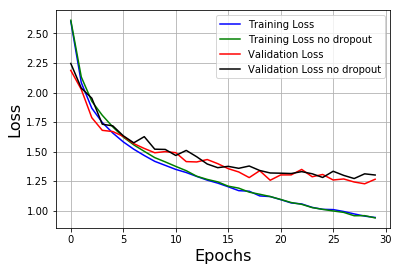

In [8]:
# Losses
pylab.grid()
pylab.xlabel('Epochs', fontsize=16)
pylab.ylabel('Loss', fontsize=16)
t_l, = pylab.plot(range(30), train_loss,'-b', label="Training Loss")
t_l_v = pylab.plot(range(30), train_loss_vanilla,'-g', label="Training Loss no dropout")
v_l, = pylab.plot(range(30),val_loss, '-r',label="Validation Loss")
v_l_v, = pylab.plot(range(30),val_loss_vanilla, '-k',label="Validation Loss no dropout")
pylab.legend()

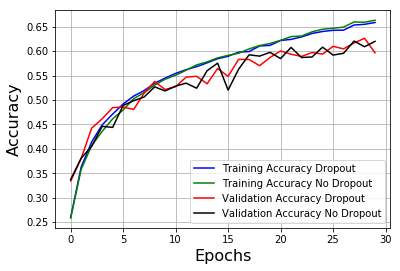

In [9]:
pylab.grid()
pylab.xlabel('Epochs', fontsize=16)
pylab.ylabel('Accuracy', fontsize=16)
t_l, = pylab.plot(range(30), train_acc,'-b', label="Training Accuracy Dropout")
t_l_v = pylab.plot(range(30), train_acc_vanilla,'-g', label="Training Accuracy No Dropout")
v_l, = pylab.plot(range(30),val_acc, '-r',label="Validation Accuracy Dropout")
v_l_v, = pylab.plot(range(30),val_acc_vanilla, '-k',label="Validation Accuracy No Dropout")
pylab.legend()

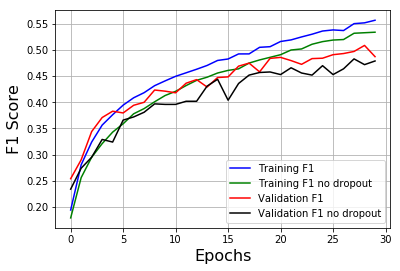

In [10]:
# F1 score
pylab.grid()
pylab.xlabel('Epochs', fontsize=16)
pylab.ylabel('F1 Score', fontsize=16)
t_l, = pylab.plot(range(30), train_F,'-b', label="Training F1")
t_l_v = pylab.plot(range(30), train_F_vanilla,'-g', label="Training F1 no dropout")
v_l, = pylab.plot(range(30),val_F, '-r',label="Validation F1")
v_l_v, = pylab.plot(range(30),val_F_vanilla, '-k',label="Validation F1 no dropout")
pylab.legend()

### CONCLUSION
Having added some dropout layers, our new network has learnt how to genearlize better. Before we achieved 
an accuracy of 62 % and F1 = 0.483. However, now we have improved these results, achieving an accuracy of 
62.6 % and F1 = 0.508. Nevertheless, in the next section, "Inference on Test data", we are going to see 
a confusion matrix from which we will derive that our classifier can be enhanced by using a contrastive 
loss and siamese networks. This is explained in the last notebook: Siamese.


### INFERENCE ON TEST DATA

Now we will predict a single image and visualize the confusion matrix.

Predicted class: 3Crotalus Horridus
Since we are in the test set and we don't have labels, we can look for the species in google images and comparequalitatively the result


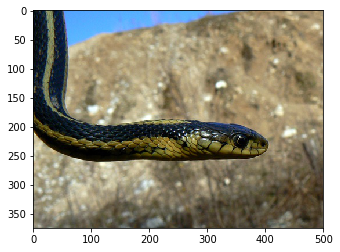

In [11]:
test_path = '/home/user/test/round1/'
class_name = ['Thamnophis Proximus', 'Nerodia Sipedon', 'Opheodrys Vernalis', 'Crotalus Horridus', 'Crotalus Pyrrhus', 'Nerodia Rhombifer', 'Thamnophis Sirtalis', 'Natrix Natrix', 'Crotalus Adamanteus', 'Charina Bottae', 'Pituophis Catenifer', 'Lampropeltis Triangulum', 'Nerodia Erythrogaster', 'Thamnophis Marcianus', 'Lampropeltis Californiae', 'Crotalus Ruber', 'Rhinocheilus Lecontei', 'Opheodrys Aestivus', 'Thamnophis Ordinoides', 'Thamnophis Radix', 'Masticophis Flagellum', 'Pantherophis Vulpinus', 'Hierophis Viridiflavus', 'Feterodon Platirhinos', 'Pantherophis Emoryi', 'Regina Septemvittata', 'Haldea Striatula', 'Diadophis Punctatus', 'Nerodia Fasciata', 'Storeria Occipitomaculata', 'Crotalus Scutulatus', 'Storeria Dekayi', 'Crotalus Viridis', 'Boa Imperator', 'Pantherophis Obsoletus', 'Lichanura Trivirgata', 'Agkistrodon Contortrix', 'Thamnophis Elegans', 'Agkistrodon Piscivorus', 'Pantherophis Guttatus', 'Crotalus Atrox', 'Carphophism Amoenus', 'Coluber Constrictor', 'Pantherophis Spiloides', 'Pantherophis Alleghaniensis']

# The model accepts images of size 224x224
scaler = transforms.Resize((224, 224))
# The model accepts data in a [0,1] range. Then we have to normalize it according to the following rule.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# This line converts the PIL image to a pytorch tensor
to_tensor = transforms.ToTensor()

# Single image inference
test_images = os.listdir(test_path)
number_of_test_images = len(test_images)
img_idx = int(np.random.randint(0, number_of_test_images,1))
img_name = os.path.join(test_path, test_images[img_idx])
img = Image.open(img_name)
plt.imshow(img)
t_img = (normalize(to_tensor(scaler(img))).unsqueeze(0)).to(device)
model.eval()
model = model.to(device)
out = model(t_img)
_, preds = torch.max(out, 1)
print("Predicted class: " + str(preds.item()) + str(class_name[preds.item()]))
print("Since we are in the test set and we don't have labels, we can look for the species in google images and compare" 
      "qualitatively the result")

Now let us compute the confusion matrix.

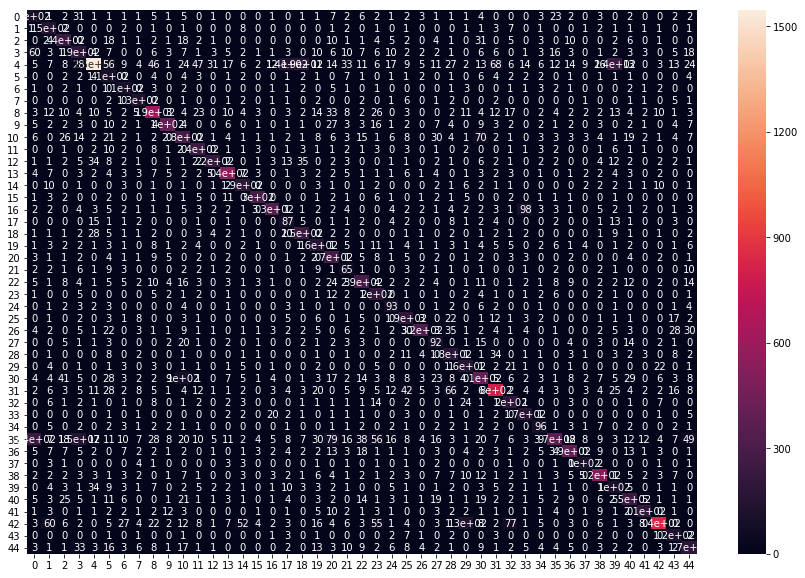

In [13]:
model = torchvision.models.resnet50(pretrained=True, progress=True)

num_ftrs = model.fc.in_features

# Add dropout layers
model.layer4[1].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)
model.layer4[2].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)
# Change the last layer to classify 45 classes instead of 1000 and add dropout
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, C)
)

# Now load the pretrained
model_weights_path = '/home/user/finetuning/resnet50_snakes_drop_Ep_28_Acc_0.626_F_0.509.pth'
model_weights = torch.load(model_weights_path)
model.load_state_dict(model_weights)
# Now set the model to evaluation mode
model.eval()

# Now make a forward pass through all the training set and build a confusion matrix saving each sample-id
model = model.to(device)

cm = np.zeros((C,C))
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu()
    indices = torch.eq(labels, preds).numpy()
    #print("Labels:")
    #print(labels)
    #print(preds)
    wrong_classification = np.where(indices == 0)
    correct_classification = np.where(indices == 1)
    #print(wrong_classification[0])
    for i in wrong_classification[0]:
        cm[labels[i], preds[i].item()] += 1
    
    for i in correct_classification[0]:
        cm[labels[i],preds[i].item()] += 1
    
# Plot confusion matrix cm
df_cm = pd.DataFrame(cm, index = [i for i in range(0, C)],
                  columns = [i for i in range(0, C)])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)

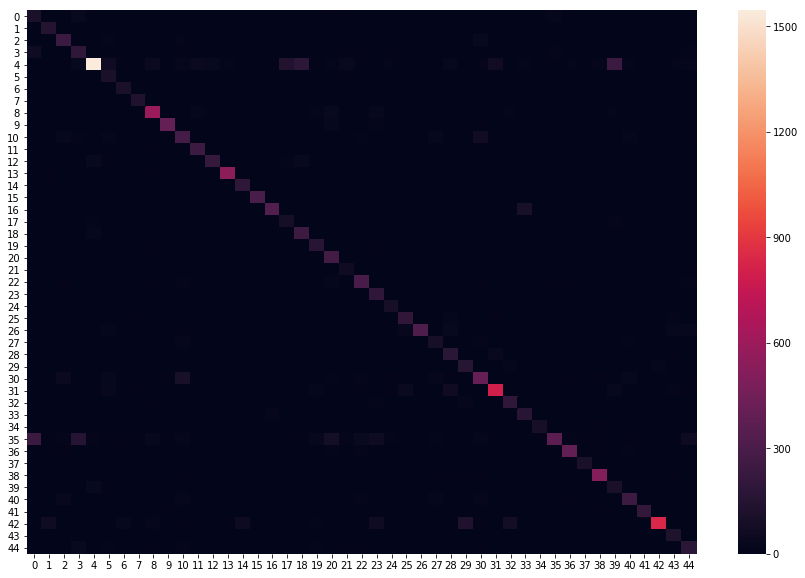

In [14]:
# Let us see a better representation without the numbers
plt.figure(figsize = (15,10))
sn.heatmap(df_cm)

The vertical axis (rows) represents the actual class and the horizontal axis (columns) represents the predicted class. As we can see, there are many examples that are missclassified. For example, in the first column we can see that the classifier missclassifies a lot of examples of class 35 as class 0. Let us visualize to images to see how these two classes look like. We will improve this confusion with the siamese network.

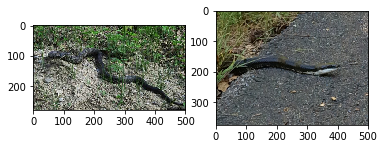

In [50]:
def pick_image(class_dir):
    def_imgs = []
    for direc in class_dir:
        images = os.listdir(direc)
        number_of_images = len(images)
        img_idx = int(np.random.randint(0, number_of_images,1))
        img_name = os.path.join(direc, images[img_idx])
        img = Image.open(img_name)
        def_imgs.append(img)
    return def_imgs
# Pick a random image from the two classes 0 and 35 and visualize it
class0 = '/home/user/snakes/validation/' + validation_set.classes[0]
class35 = '/home/user/snakes/validation/' + validation_set.classes[35]
classes = [class0, class35]
imgs = pick_image(classes)
plt.subplot(121)
plt.imshow(imgs[0])
plt.subplot(122)
plt.imshow(imgs[1])